We recently published an [application note](https://pubs.acs.org/doi/full/10.1021/acs.jcim.4c01133) introducing [lwreg](https://github.com/rinikerlab/lightweight-registration), an open-source chemical registration system with a simple Python API that can be easily integrated into computational workflows. We think lwreg is really useful and hope others agree with us.

One of the key ideas behind lwreg is that it should not require any chemical intelligence in the database it uses to store its results. See the paper for more details, but the kinds of identity queries (i.e. "is this molecule or something closely related already registered?") that a registration system needs to support can be answered with standard text queries. Having said that, there are times when it's useful to ask questions like "Are there any registered molecules in the database that contain this substructure?". One easy way to allow this kind of query is to install the RDKit cartridge in the database.

This post shows how to use the RDKit cartridge together with an lwreg instance that is using PostgreSQL as the database backend. Since installing PostgreSQL and the cartridge can be challenging for a normal user, I also show how to do that installation and get a database that's suitable for local use. The instructions below should work on Windows, Linux, or the Mac.

Many thanks to Jessica Braun, the other main lwreg developer, for her feedback on a draft of this post, which will eventually end up, in some modified form, in the lwreg documentation.

# Setting up a local postgresql installation

You probably wouldn't want to use this setup in any very serious way, but it's great for learning and could certainly work as a way to configure a personal database. I put this notebook together in Windows on my laptop, but it should work on Linux or the Mac too. 

> **Aside** If you want to do this more seriously without a huge amount of complication, your best bet is probably to setup a docker container that runs postgresql and the cartridge and to use that within lwreg. I will try to put together a post showing how to do this in the not-too-distant future.

As usual, I assume that you're using conda since it makes installing the RDKit and all other dependencies incredibly easy.

Create a conda environment using the lwreg environment.yml file:
```
conda env create -f https://github.com/rinikerlab/lightweight-registration/raw/refs/heads/main/environment.yml
```
This creates an environment named `py311_lwreg`. Activate that and install lwreg, postgresql, and the rdkit-postgresql cartridge:
```
conda activate py311_lwreg
python -m pip install git+https://github.com/rinikerlab/lightweight-registration
conda install postgresql
conda install rdkit-postgresql
```

We need an environment for postgresql to use to store its database files, create that and then tell postgresql to initialize that directory, you will obviously need to pick a different path:
```
mkdir c:/users/glandrum/database
initdb -D /c/Users/glandrum/database/psql17
```
Start the postgresql server:
```
pg_ctl -D /c/Users/glandrum/database/psql17 -l /c/Users/glandrum/database/psql17.log start
```
> **Note** If you run the server this way, it will be killed when the shell you launched it from exits. You will need to run this start command each time you want to start using lwreg.

Finally create the database that we're going to work with here:
```
createdb gl_structuredemo
```
Now everything is set up, let's get started!


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from lwreg import utils

Set up our the configuration we're going to use for lwreg:

In [2]:
cfg = utils.defaultConfig()
cfg['host'] = 'localhost'
cfg['dbtype'] = 'postgresql'
cfg['dbname'] = 'gl_structuredemo'
# for this use case we're going to be registering 3D structures and want to keep the conformers:
cfg['registerConformers'] = True
# we don't want lwreg to do any standardization of the molecules when we load them:
cfg['standardization'] = 'none'
utils.set_default_config(cfg)

In [3]:
utils.initdb()

This will destroy any existing information in the registration database.


  are you sure? [yes/no]:  yes


True

Start by loading some structures (these are some subsets of molecules I've extracted from the COD for another project). You obviously won't have these files, but you can provide any SDF files that contain 3D molecules.

In [4]:
mrns = utils.bulk_register(sdfile='c:/users/glandrum/ETH/Datasets/COD/COD_2024Feb14.organic.chembl_selected.sdf')
mrns = utils.bulk_register(sdfile='c:/users/glandrum/ETH/Datasets/COD/COD_2024Feb14.organic.macrocycles.sdf')
mrns = utils.bulk_register(sdfile='c:/users/glandrum/ETH/Datasets/COD/COD_2024Feb14.organic.cages.sdf')

In [5]:
len(utils.get_all_registry_numbers())

2416

# Using the RDKit cartridge with data from the lwreg tables.

We start by installing the cartridge in our database (if it's not already installed) and create a new schema to hold the RDKit tables.

In [6]:
cn = utils.connect(config=cfg)
curs = cn.cursor()
curs.execute('create extension if not exists rdkit')
curs.execute('create schema if not exists rdk')
cn.commit()

Now create the `rdk.mols` table to hold RDKit molecules, populate it with molecules created from the mol blocks in lwreg's `molblocks` table, and then create an index on the molecule column to allow us to quickly do substructure searches.

In [7]:
curs.execute('drop table if exists rdk.mols cascade')
# the second argument to mol_from_ctab() here tells the cartridge to not store the molecule's conformers, we don't need them
curs.execute('select molregno, mol_from_ctab(molblock::cstring,false) m into rdk.mols from molblocks')
curs.execute('create index molidx on rdk.mols using gist(m)')
cn.commit()

Now let's do some queries.

Start by looking for one of the torsions that's used for ETKDGv3:

In [8]:
smi = '[cH0:1][c:2]([cH1])!@;-[O:3][C:4]'
curs.execute("select * from rdk.mols where m @> %s::qmol",(smi,))
d = curs.fetchall()
len(d)

99

And look at the results with just the torsion substructure highlighted:

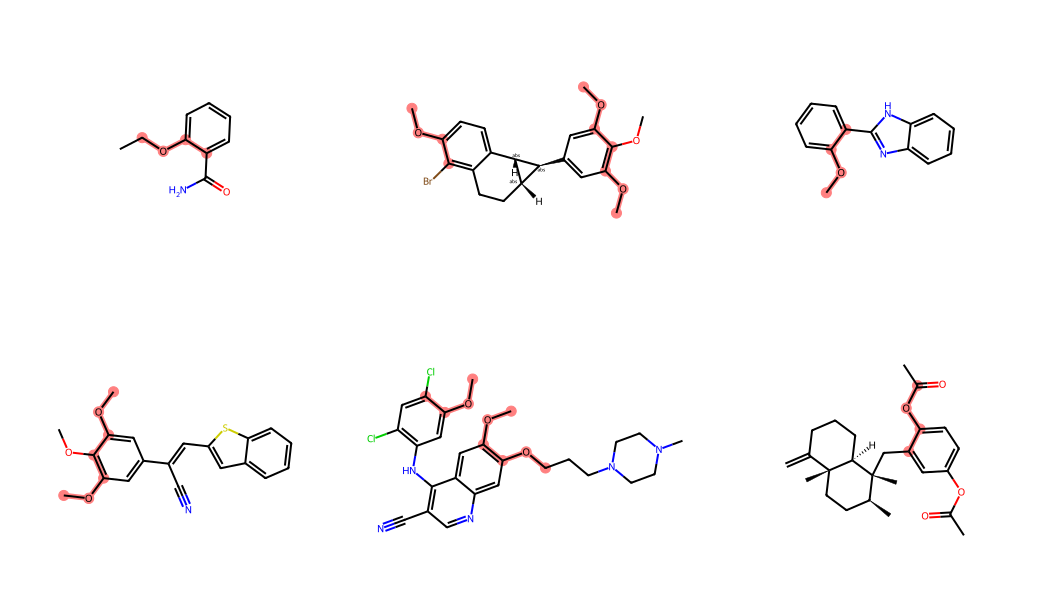

In [9]:
q = Chem.MolFromSmarts(smi)
labelledAts = [x.GetIdx() for x in q.GetAtoms() if x.GetAtomMapNum()]

ms = [Chem.MolFromSmiles(x[1]) for x in d]
ats = []
for m in ms:
    matches = m.GetSubstructMatches(q)
    tl = []
    for tm in matches:
        tl.extend([tm[i] for i in labelledAts])
    ats.append(tl)
    
Draw.MolsToGridImage(ms[:6],subImgSize=(350,300),highlightAtomLists=ats)

Now let's do a query to retrieve conformers for the molecules that match that substructure:

In [10]:
curs.execute("select molregno,conf_id,molblock from rdk.mols join conformers using (molregno) where m@>%s::qmol",(smi,))
d = curs.fetchall()
len(d)

106

And collect information about the values of the dihedral that we're interested in across those conformers:

In [11]:
from rdkit.Chem import rdMolTransforms

q = Chem.MolFromSmarts(smi)
labelledAts = [x.GetIdx() for x in q.GetAtoms() if x.GetAtomMapNum()]

ms = [Chem.MolFromMolBlock(x[2],removeHs=False) for x in d]
vals = []
for m in ms:
    matches = m.GetSubstructMatches(q)
    conf = m.GetConformer()
    for tm in matches:
        aids = [tm[i] for i in labelledAts]
        vals.append(rdMolTransforms.GetDihedralDeg(conf,*aids))    

In [12]:
len(vals)

219

Do a histogram of the dihedral values:

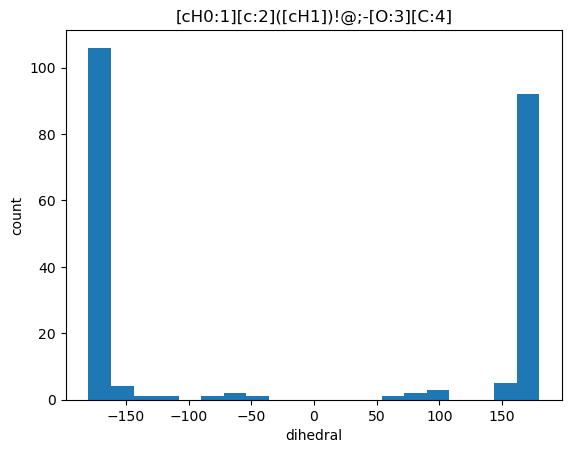

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.hist(vals,bins=20);
plt.xlabel('dihedral')
plt.ylabel('count')
plt.title(smi);

# Keeping the RDKit tables up-to-date when molecules are added to lwreg

Our next step is to make sure that RDKit tables in the database are automatically updated when new molecules are added to lwreg.
We can do this in PostgreSQL by adding a `trigger` to the `molblock` table that is called after a new row is inserted into the `molblock` table. The trigger is called with the data from the new row, so we can just insert the new molregno and the molecule constructed from the new molblock into the `rdk.mols` table.

Note: if using this in production, you probably would need to do some error handling in the trigger. That's beyond the scope of this blog post (in this case that means: "I don't know how to do it").

The PostgreSQL docs have [more information about creating triggers](https://www.postgresql.org/docs/current/sql-createtrigger.html).



In [14]:
curs.execute('''CREATE OR REPLACE FUNCTION copy_new_mol() RETURNS TRIGGER AS
$BODY$
BEGIN
    INSERT INTO
        rdk.mols(molregno,m)
        VALUES(new.molregno,mol_from_ctab(new.molblock::cstring,false));
           RETURN new;
END;
$BODY$
language plpgsql;''')
curs.execute('''CREATE OR REPLACE TRIGGER mol_insert_trigger
     AFTER INSERT ON molblocks
     FOR EACH ROW
     EXECUTE FUNCTION copy_new_mol();''')



Demonstrate that this worked by creating two new molecules that share a core, generating a conformer for each one, and registering each one.

In [15]:
from rdkit.Chem import rdDistGeom
newMol = Chem.AddHs(Chem.MolFromSmiles('c1c(O)csn1'))
rdDistGeom.EmbedMolecule(newMol,randomSeed=0xf00d)
tm = Chem.RemoveHs(newMol)
utils.register(mol=tm)

(2792, 2792)

In [16]:
newMol = Chem.AddHs(Chem.MolFromSmiles('c1c(OC)csn1'))
rdDistGeom.EmbedMolecule(newMol,randomSeed=0xf00d)
tm = Chem.RemoveHs(newMol)
utils.register(mol=tm)

(2793, 2793)

Now show that we can retrieve those two just-registered molecules with a substructure query for the core:

In [17]:
sma = 'c1c(O)csn1'
curs.execute("select * from rdk.mols where m@>%s::qmol limit 10",(sma,))
d = curs.fetchall()
len(d)

2

In [18]:
d[0]

(2792, 'Oc1cnsc1')

In [20]:
d[1]

(2793, 'COc1cnsc1')